In [1]:
#embedding_layer.ipynb 
# 
#by Joe Hahn
#joe.hahn@oracle.com
#27 July 2018
#
#train an embedding layer on the XO dataset

In [2]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 0.01#1.0
rn_seed = 15
initial_id = 0

In [3]:
#start time
import time as tm
time_start = tm.time()

In [4]:
#generate training data
N_dots = 26700
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
train = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
train.tail()

,id,x,y,r,angle,class,X_score,O_score,B_score
record,,,,,,,,,
26695,26695,-0.615759,-3.179028,3.238113,-1.762121,O,0.0,1.0,0.0
26696,26696,-0.887397,2.754092,2.893527,1.882503,O,0.0,1.0,0.0
26697,26697,1.775499,-5.042810,5.346244,-1.232265,B,0.0,0.0,1.0
26698,26698,2.679914,2.634903,3.758278,0.776929,X,1.0,0.0,0.0
26699,26699,0.579441,3.669365,3.714834,1.414177,B,0.0,0.0,1.0


In [5]:
#rebalance training data
print train.groupby('class')['id'].count()
df = train
idx_O = (df['class'] == 'O')
idx_X = (df['class'] == 'X')
idx_B = (df['class'] == 'B')
df = df[idx_O].append(df[idx_X]).append(df[idx_B].sample(n=idx_O.sum()))
df['ran_num'] = np.random.uniform(size=len(df))
train_balanced = df.sort_values('ran_num').reset_index(drop=True)
print train_balanced.groupby('class')['id'].count()
train_balanced.tail()

class
B    19675
O     3369
X     3656
Name: id, dtype: int64
class
B    3369
O    3369
X    3656
Name: id, dtype: int64


,id,x,y,r,angle,class,X_score,O_score,B_score,ran_num
10389,14,-4.711799,-0.710390,4.765050,-2.991951,B,0.0,0.0,1.0,0.999518
10390,11820,0.102775,9.221555,9.222128,1.559652,B,0.0,0.0,1.0,0.999542
10391,25265,-0.774489,0.033945,0.775233,3.097791,O,0.0,1.0,0.0,0.999688
10392,26268,0.388413,5.652433,5.665762,1.502188,B,0.0,0.0,1.0,0.999760
10393,6534,5.477345,2.111265,5.870157,0.367904,B,0.0,0.0,1.0,0.999987


In [6]:
#select x-features and y = target variables = class-scores
x_cols = ['x', 'y']
y_cols = ['O_score', 'X_score', 'B_score']
x = train_balanced[x_cols].values
y = train_balanced[y_cols].values
print 'x.shape = ', x.shape
print 'y.shape = ', y.shape
x

x.shape =  (10394, 2)
y.shape =  (10394, 3)


array([[-3.27822834,  1.60884291],
       [-1.58303759, -0.61507829],
       [ 3.36211344, -4.50535143],
       ..., 
       [-0.77448946,  0.03394548],
       [ 0.38841345,  5.65243275],
       [ 5.47734495,  2.11126515]])

In [7]:
#model parameters
N_input = len(x_cols)
N_output = len(y_cols)
vocab_size = 100
embedding_dimension = vocab_size

In [8]:
#rescale x so 0 <= x < vocab_size
x = x - x.min()
x /= x.max()
x *= vocab_size - 1
x = x.astype(int)
#pad x with zeros
max_length = vocab_size
from keras.preprocessing.sequence import pad_sequences
x = pad_sequences(x, maxlen=max_length, padding='post')
N_input = x.shape[1]
print 'x.min() = ', x.min()
print 'x.max() = ', x.max()
print 'vocab_size, embedding_dimension, N_input = ', vocab_size, embedding_dimension, N_input
print 'x.shape = ', x.shape
x_train = x
y_train = y
x_train

Using TensorFlow backend.


x.min() =  0
x.max() =  99
vocab_size, embedding_dimension, N_input =  100 100 100
x.shape =  (10394, 100)


array([[32, 57,  0, ...,  0,  0,  0],
       [41, 46,  0, ...,  0,  0,  0],
       [66, 26,  0, ...,  0,  0,  0],
       ..., 
       [45, 49,  0, ...,  0,  0,  0],
       [51, 77,  0, ...,  0,  0,  0],
       [76, 59,  0, ...,  0,  0,  0]], dtype=int32)

In [9]:
#generate validation data
#...generate XO data and rebalance
df = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
idx_O = (df['class'] == 'O')
idx_X = (df['class'] == 'X')
idx_B = (df['class'] == 'B')
df = df[idx_O].append(df[idx_X]).append(df[idx_B].sample(n=idx_O.sum()))
df['ran_num'] = np.random.uniform(size=len(df))
df = df.sort_values('ran_num').reset_index(drop=True)
print df.groupby('class')['id'].count()
x = df[x_cols].values
y = df[y_cols].values
#rescale so 0<x<vocab_size
x = x - x.min()
x /= x.max()
x *= vocab_size - 1
x = x.astype(int)
#pad x with zeros
x = pad_sequences(x, maxlen=max_length, padding='post')
print 'x.min() = ', x.min()
print 'x.max() = ', x.max()
print 'vocab_size, embedding_dimension, N_input = ', vocab_size, embedding_dimension, N_input
print 'x.shape = ', x.shape
x_val = x
y_val = y
x_val

class
B    3354
O    3354
X    3669
Name: id, dtype: int64
x.min() =  0
x.max() =  99
vocab_size, embedding_dimension, N_input =  100 100 100
x.shape =  (10377, 100)


array([[32, 50,  0, ...,  0,  0,  0],
       [22, 48,  0, ...,  0,  0,  0],
       [41, 62,  0, ...,  0,  0,  0],
       ..., 
       [52, 38,  0, ...,  0,  0,  0],
       [66, 68,  0, ...,  0,  0,  0],
       [61, 53,  0, ...,  0,  0,  0]], dtype=int32)

In [10]:
#this helper function builds an embedding classifier composed of single embedding layer
def embedding_classifier(vocab_size, embedding_dimension, N_input, N_output):
    from keras.models import Sequential
    from keras.layers.embeddings import Embedding
    from keras.layers import Flatten
    from keras.layers import Dense
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dimension, input_length=N_input))
    model.add(Flatten())
    model.add(Dense(N_output, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model

In [11]:
#build embedding classification model
print 'vocab_size = ', vocab_size
print 'embedding_dimension = ', embedding_dimension
print 'N_input = ', N_input
print 'N_output = ', N_output
print 'x.shape = ', x.shape
model = embedding_classifier(vocab_size, embedding_dimension, N_input, N_output)
model.summary()

vocab_size =  100
embedding_dimension =  100
N_input =  100
N_output =  3
x.shape =  (10377, 100)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          10000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 30003     
Total params: 40,003
Trainable params: 40,003
Non-trainable params: 0
_________________________________________________________________


In [12]:
#fit model to the training data
N_training_epochs = 100
batch_size = len(x_train)/10
model = embedding_classifier(vocab_size, embedding_dimension, N_input, N_output)
fit_history = model.fit(x_train, y_train, epochs=N_training_epochs, batch_size=batch_size, verbose=0, \
    validation_data=(x_val, y_val))

In [13]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

final validation loss =  0.405252778638


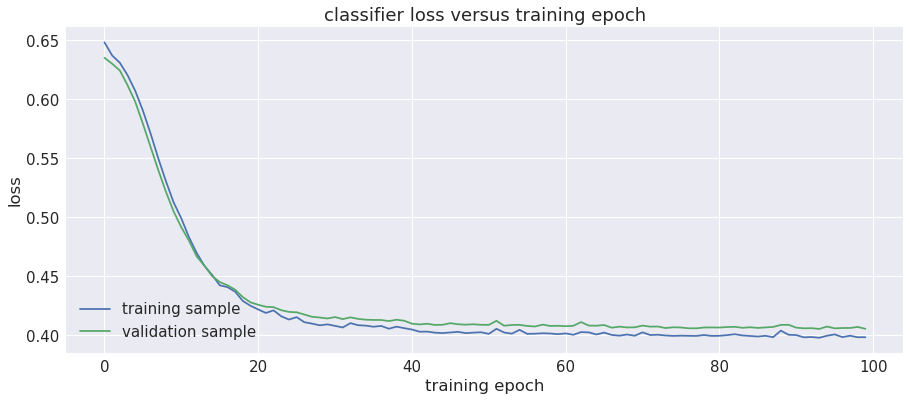

In [14]:
#plot accuracy vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, label='validation sample')
ax.set_title('classifier loss versus training epoch')
ax.set_ylabel('loss')
ax.set_xlabel('training epoch')
ax.legend(loc='lower left')
ax.set_ylim(0.95*np.min(yp[1:]), 1.05*np.max(yp[1:]))
plt.savefig('figs/mlp_loss.png')
print 'final validation loss = ', yp[-1]

In [15]:
#generate testing data
#...generate XO data and rebalance
df = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
x = df[x_cols].values
y = df[y_cols].values
#rescale so 0<x<vocab_size
x = x - x.min()
x /= x.max()
x *= vocab_size - 1
x = x.astype(int)
#pad x with zeros
x = pad_sequences(x, maxlen=max_length, padding='post')
print 'x.min() = ', x.min()
print 'x.max() = ', x.max()
print 'vocab_size, embedding_dimension, N_input = ', vocab_size, embedding_dimension, N_input
print 'x.shape = ', x.shape
x_test = x
y_test = y
xy = df

x.min() =  0
x.max() =  99
vocab_size, embedding_dimension, N_input =  100 100 100
x.shape =  (26700, 100)


In [16]:
#generate predicted class probabilities and their predicted X,O,B
y_pred = model.predict(x_test)
for idx in range(len(y_cols)):
    y_col = y_cols[idx]
    xy[y_col] = y_pred[:, idx]
idx = (xy.O_score > xy.X_score) & (xy.O_score > xy.B_score)
xy.loc[idx, 'class_pred'] = 'O'
idx = (xy.X_score > xy.B_score) & (xy.X_score > xy.O_score)
xy.loc[idx, 'class_pred'] = 'X'
idx = (xy.B_score > xy.O_score) & (xy.B_score > xy.X_score)
xy.loc[idx, 'class_pred'] = 'B'
loss, accuracy = model.evaluate(x, y, verbose=0)
print 'testing loss = ', loss
print 'testing accuracy = ', accuracy
xy.head()

testing loss =  0.358412196158
testing accuracy =  0.798676663874


,id,x,y,r,angle,class,X_score,O_score,B_score,class_pred
record,,,,,,,,,,
0,0,-1.856525,-1.419875,2.337248,-2.488685,X,0.434166,0.471471,0.070499,O
1,1,1.524477,-4.046962,4.324573,-1.210539,B,0.628289,0.021705,0.190147,X
2,2,-7.480223,-0.124274,7.481255,-3.124980,B,0.001466,0.004242,0.997877,B
3,3,0.840034,5.272002,5.338508,1.412786,B,0.220211,0.011470,0.625273,B
4,4,6.266519,3.323539,7.093319,0.487643,B,0.007805,0.001914,0.993831,B


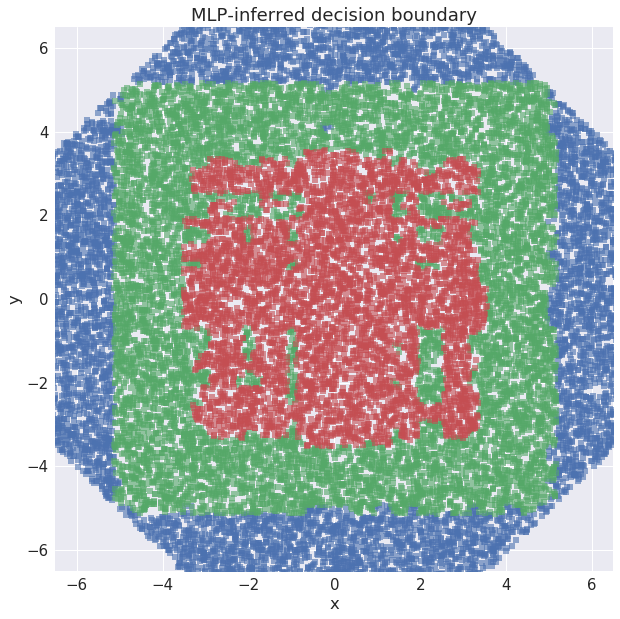

In [17]:
#scatterplot showing model's predicted decision boundaries
df = xy
xy_rng = (-6.5, 6.5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('MLP-inferred decision boundary')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
#plt.savefig('figs/mlp_decision_boundary.png')

In [18]:
#done
time_stop = tm.time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0

execution time (minutes) =  0.950392814477
